# Assignment 1 - CNN's and VGG16

*In this assingment, you will further familiraize yourself with CNN's and how to implement them. For this particular example, we will ask you to implement the layer structure of VGG16, an old but fairly effective and simple CNN structure.*

*Keep in mind, that while VGG16 and other CNN's you have implemented so far, only incoporate convolutions and pooling layers, many state-of-the-art models  use a variety of other techniques, such as skip connections (CITATION NEEDED), or self-attention (CITATION NEEDED) to get better results.*

*As you write code for this assignment, try to keep in mind to write good code. That might sound vague, but just imagine that some other poor sod will have to read your code at some point, and easily readable, understandable code, will go a long way to making their life easier. However, this is not a coding course, so the main focus should of course be on the exercises themselves.*

**Keep in mind, this assignment does not count towards your final grade in the course. When any of the exercises mention 'grading', it refers to commenting and correcting answers, not necessarily giving you a score which will reflect in your grade, so dw :)**


**Hand-in date is 8/10 at the latest if you want to recieve feedback!!**

## Boilerplate start - you can mostly ignore this!

In [1]:
import os
import torch
import PIL
from torch import nn
from torch.utils.data.dataloader import default_collate

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary

import utils

# Check if you have cuda available, and use if you do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set a random seed for everything important
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

# Set a seed with a random integer, in this case, I choose my verymost favourite sequence of numbers
seed_everything(sum([115, 107, 105, 98, 105, 100, 105, 32, 116, 111, 105, 108, 101, 116]))

cpu


In [16]:
# Specify dataset you wanna use
def get_dataset(dataset_name, validation_size=0.1, transform=None, v=True):

    if transform is None:
        transform = ToTensor()

    if dataset_name == 'cifar10':
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform())
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform())

        # Purely for our convenience - Mapping from cifar labels to human readable classes
        cifar10_classes = {
            0: 'airplane',
            1: 'automobile',
            2: 'bird',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse',
            8: 'ship',
            9: 'truck'
        }

    elif dataset_name == 'mnist':
        train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
        test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

    elif dataset_name == 'imagenette':
        download = not os.path.exists('./data/imagenette2')

        # Specific transform in the case we use imagenette
        imagenette_transform = transforms.Compose([
            transforms.Resize(256),        # Resize to 256x256
            transforms.RandomCrop(224),    # Crop the center to 224x224
            transforms.ToTensor(),         # Convert to tensor
            transforms.Normalize(mean=[0.4650, 0.4553, 0.4258], std=[0.2439, 0.2375, 0.2457]) # Normalize each image, numbers because of function courtesy of chatgpt
        ])
        train_set = datasets.Imagenette(root='./data', split='train', download=download, size='full', transform=imagenette_transform)
        test_set = datasets.Imagenette(root='./data', split='val', download=False, size='full', transform=imagenette_transform)
    
    # If we want a validation set of a given size, take it from train set
    if validation_size is not None:
        # These will both be of the torch.utils.data.Subset type (not the Dataset type), and are basically just mappings of indices
        # This does not matter when we make Dataloaders of them, however
        if dataset_name != 'imagenette':
            train_set, validation_set = torch.utils.data.random_split(train_set, [1-validation_size, validation_size])

        # In the case of imagenette, the 'test set' is already a pretty big validation set, so we'll use that to create the test set instead
        else:
            validation_set, test_set = torch.utils.data.random_split(test_set, [validation_size, 1-validation_size])

    if v:
        print(f"There are {len(train_set)} examples in the training set")
        print(f"There are {len(test_set)} examples in the test set \n")

        print(f"Image shape is: {train_set[0][0].shape}, label example is {train_set[0][1]}")

    return train_set, validation_set, test_set

# collate function just to cast to device, same as in week_3 exercises
def collate_fn(batch):
    return tuple(x_.to(device) for x_ in default_collate(batch))

## Theoretical questions

*These questions are meant to test your general knowledge of CNN's, feel free to contact or write the TA's if you have any questions about any of them*

### Exercise 1.1

**1. What is the reason we add MaxPooling or AveragePooling in CNN's?**

ASNWER: (Week 3, slide 15) To reduce the spatial dimensions (height and width) of the feature maps, which serves several purposes:
 - **Dimensionality Reduction:** Pooling reduces the size of the input, which lowers the computational cost and memory usage. By downsampling the feature maps, we decrease the number of parameters in the network, making the model more efficient and faster to compute.
 - **Retain Important Features:**
    - **MaxPooling:** Preserves important features; it selects the maximum value in each pool, retaining only the most dominant or important features from each region. This is useful for capturing the most critical patterns in the data.
    - **AveragePooling:** computes the average of the values in each pool, which smooths the feature map and is useful when we want to retain overall information and reduce noise.
 - **Discards less important positional information:** By reducing the resolution of the feature maps, pooling forces the network to focus on the most important features and discard less relevant or noisy details. This simplification can help reduce the risk of overfitting to the training data.


**\*2. Say a network comes with a list of class probabilities:** $\hat{p}_1, \hat{p}_2, \dots \hat{p}_N$ **when is the cross-entropy in regards to the *true* class probabilities:** $p_1, p_2, \dots p_N$ **maximized?**

ANSWER: The cross-entropy is maximized when the predicted probability $\hat{p}_i$ for the true class is as far from 1 as possible—in other words, when $\hat{p}_i=0$ for the true class.

**Explanation:**

Formula: $$ \text{Cross-Entropy}(p, \hat{p}) = - \sum_{i=1}^{N} p_i \log(\hat{p}_i) $$
where:
 - $p_i$ is the true probability (1 for the true class and 0 for all other classes).
 - $\hat{p}_i$ is the predicted probability for class $i$.

 Since $p_i$ (the true probability) is 1 for the correct class and 0 for all other classes, only the term where $p_i=1$ contributes to the sum. In other words, for a given data point, cross-entropy can be simplified to:
 $$ \text{Cross-Entropy}(p, \hat{p}) = -\log(\hat{p}_{\text{true class}}) $$
 
 Cross-entropy is maximized when the network assigns a probability of 0 to the true class. This is because $\log{(0)}$ tends to negative infinity, and the cross-entropy loss becomes very large. Therefore, the worst-case scenario (maximum cross-entropy) occurs when the network is most confident in an incorrect class (i.e., $\hat{p}_i=0$ for the correct class).

 **Ekstra:**

 This results in the following domino effect:
  1. **Bigger penalty = Larger loss:**  The more confident a model is in incorrectly labeling the true class (i.e, when $\hat{p}_i=0$ for the true class), the larger the cross-entropy loss becomes. Additionally, a penalty term (such as L2 regularization) may be *added* to the total loss to prevent overfitting by discouraging excessively large model weights.\
  Total loss: $$ \text{Total Loss (example with L2 regularization)} = \text{Cross-Entropy Loss} + \lambda \sum_{i=1}^{n} w_i^2 $$
  2. **Larger Loss = Steeper Gradient:**
   - In gradient-based optimization methods (such as stochastic gradient descent, SGD), the gradient of the loss function with respect to the model’s parameters tells us how to adjust the parameters to reduce the loss.\
   SGD formula: $ \theta \leftarrow \theta - \eta \nabla_{\theta} \mathcal{L}(\theta) $
   - The larger the loss, the steeper the gradient. A steep gradient means that small changes in the model parameters will cause large changes in the loss.
   3. **Steeper Gradient = Larger Parameter Updates:** A steeper gradient results in larger updates to the model’s weights during training (assuming the learning rate is constant). This means the model adjusts its weights more dramatically in response to larger losses, causing it to learn more quickly when the predictions are very wrong.
   4. **Faster Learning:** When the model makes a large error (for example, predicting a very low probability for the true class), the larger gradient will result in a larger update to the weights, effectively allowing the model to "learn faster" in those regions. This helps the model correct its large mistakes more quickly in the next iteration.

**3. In the [VGG paper](https://arxiv.org/pdf/1409.1556), last paragraph of 'training', page 4, they mention images being randomly cropped after being rescaled. Why do you think they crop images only *after* rescaling them?**

ANSWER:
 - When you rescale an image to a large you maintain the overall context of the image.
 - Cropping before rescaling could result in cropped regions that are too small, and when rescaled, they may become
 blurry or lose important details.


**4. After this, they mention "further augmenting the dataset" by random horizontal flipping and random RGB color shift. Why do you think they do this?**

ANSWER:

 - **Random Horizontal flipping:**
 
   Horizontal flip in computer vision means flipping the image from left to right along a vertical axis (think of a mirror placed on one side of the image).
 
   Objects can appear in various orientations. For instance, an object (like a person or a dog) might appear facing left or right in different images. By flipping the image randomly, the model learns to recognize objects regardless of their horizontal orientation.

 - **Random RGB Color Shift:**
   Lighting and color conditions can vary significantly. For example, the same object could appear in different colors due to lighting, shadows, or camera settings. By randomly shifting the RGB values, the model learns to focus on the essential features of the objects (shapes, textures) rather than being sensitive to specific colors or lighting conditions.



**\*5. Why do you think they do not randomly translate images? (Translate being to move images left, right, up, down)**

1. **Risk of Cutting Out Important Features:** If you randomly translate an image (move it left, right, up, or down), parts of the object might be moved out of the frame. For example, if the object of interest (like a person or an animal) is near the edge of the image and you translate the image, parts of the object might get cut off, which could make the model fail to learn important features from the object.

2. **Image Padding Issues:** It is stated in the paper (page 3) that the convolutional layers use a spatial padding of 1 pixel for the 3x3 convolution filters. Furthermore, on page 5, it explicitly mentions that the feature maps are padded with zeros during convolution. These artificial regions don’t contain useful information for the model, and while the padding helps preserve spatial dimensions, the model should ideally not extract meaningful features from these padded regions – therefore we should keep objects away from the paddings. If the model were to mistakenly extract features from these zero-padding areas, it could confuse the model and potentially degrade performance, as the padding does not represent meaningful image content.

**6. Which of the following classification tasks do you think is more difficult for a machine learning model, and why?**
ANSWER:

- **Telling German Shepherds (Schæferhunde) from Labradors**
   - Probably the *hardest one* to classify. It would likely be this one because the sctructure of the object (dogs) is almost identical with only few expections such like:
      - The german sheperd has usually the same colors as labdradors but usually as brown with black spots instead. Also, the german sheperd has lower hips and longer hair.
- **Telling dogs from cats**
   - Probably Easier: Dogs and cats are different species, which means they have distinct visual features such as body structure, ears, tails, and facial shapes.
- **Telling horses from cars from totem poles from chainsaws**
   - Probably Easier: This is a classification task where the objects belong to very different categories (animals, vehicles, stationary objects, and tools). These categories are vastly different in terms of shape, texture, and overall structure, making it easier for a machine learning model to distinguish between them.


**7. In real life, you often find that neural networks aren't used "for everything", older and often more simple models like random forest and linear regression still dominate a lot of fields.**

- **Reason a bit about why this is the case**

ANSWER:

1. **Task Complexity and Number of Parameters:**
   - (Week 3, exercises) In fully connected layers, the number of parameters grows quadratically with image dimensions and linearly with the number of channels, expressed as $O(N^2 \times C)$.
   - In contrast, simpler models like random forests or linear regression typically have fewer parameters and are more manageable, especially for tasks that don’t require complex feature extraction.
   
2. **Transparicy:**
   - It is very often easier to explain the behavior of random forest and linear regression.
   - Neural networks, especially deep ones, are often considered “black boxes” because it’s difficult to interpret their decisions and the importance of specific features. For many use cases, this lack of transparency makes neural networks less attractive.
   
3. **Data Requirements:**
   - Neural networks generally perform better with large datasets. They need a lot of data to capture complex patterns and relationships. In cases where there is limited data, simpler models like random forests or linear regression can often perform just as well or even better than neural networks.
   - Neural networks can overfit or underperform compared to simpler models.

**\*8. When we sample from our dataloader, we sample in batches, why is this? What would be the alternatives to sampling in batches, and what impact would that have?**

ANSWER:

1. **Efficient computation:** Neural networks are typically trained using SGD (Mini-Batch SGD, not "pure SGD") or ADAM. Instead of computing gradients and updating the weights for each individual sample, processing a batch of samples at once is more efficient, especially on hardware like GPUs, which can parallelize operations.

2. **Stability in learning:** By using a batch of samples, the model can compute a more stable estimate of the gradient. The gradients based on individual samples can be noisy, leading to unstable updates. A batch average smooths out the noise and leads to more stable and controlled weight updates.

Alternatives:

1. **Full Batch Gradient Descent:** This method involves using the entire dataset to compute the gradient and update the model parameters in each step.
 - **Pros:** The gradient is more accurate because it’s computed using the entire dataset.
 - **Cons:** Since the gradients are computed based on the entire dataset, the model may generalize too much and miss important details that could be specific to smaller portions of the data.
2. **SGD (pure SGD):** weights are updated after each individual training sample, rather than using a batch of samples.
 - **Pros:** This method is very fast and allows for frequent updates.
 - **Cons:** It can be very noisy since each individual sample might lead to drastically different updates. This can cause instability in learning, and it might take longer to converge to an optimal solution.


**9. The VGG16-D conv layers all use the same kernel size. Come up with reasons for why you would use bigger/smaller kernel sizes**

ANSWER:

1. **Using Bigger Kernel Sizes:**
   - Capture Larger Context or Features: A larger kernel can capture a wider field of view, meaning it can aggregate more spatial information in a single convolution. This is useful for tasks where larger patterns (e.g., textures or global structures) are important.
   - Reduce Depth of the Network (more parameters): Bigger kernels can reduce the need for multiple convolution layers. A single larger kernel can extract features that might otherwise require multiple layers of smaller kernels to achieve a similar receptive field; the amount of parameters is increased when the kernel size is increased.
2. **Using Smaller Kernel Sizes:**
   - More Detailed Feature Extraction: Smaller kernels, like 1x1 or 2x2, focus on fine-grained details and local features. They are useful for capturing small details, edges, or textures that a larger kernel might gloss over.
   - Fewer Parameters: Smaller kernels lead to fewer parameters, making the network lighter and potentially reducing the risk of overfitting, especially on small datasets.
   - Deeper Networks and Better Hierarchical Features: Using smaller kernels allows the network to go deeper with more layers. Each layer can extract progressively more complex and abstract features, leading to better hierarchical feature extraction.

**\*10. The "new kid on the block' (relatively speaking) in NLP (Natural Language processing), is self-attention. Basically this is letting each word/token relate to each other word/token by a specific 'attention' value, vaguely showing how much they relate to one another.**

- **Would there be any problems in doing this for image processing by simply letting each pixel relate to each other pixel, so we can get spatial information that way instead?**

ANSWER:

1. **High Computational Cost:**
   - In images, the number of pixels can be very large. If each pixel were to attend to every other pixel, this would create an enormous number of pairwise relationships to compute. The computational complexity would scale quadratically with the number of pixels:  $O(N^2)$, where $N = H \times W$ and $H$ is height and $W$ is width.
   - In NLP, the number of words in a sentence is relatively small compared to the number of pixels in an image, so self-attention in NLP is computationally feasible. However, in images, dealing with thousands of pixels makes this approach far less efficient.

2. **2. Loss of Locality:**
   - In (NLP), the relationship between different words can be distant in the sequence, making it necessary to compute attention across all words. However, in image processing, local relationships between neighboring pixels are usually much more important; this is the whole back bone of CNN.



## Boilerplate end - Your implementation work begins here:

*Below, you are given a working example of a CNN, not much different from the one in the exercises of week 3. Your job is to complete the implementation questions below. *

*You do not need to do all the exercises below, or even do them in order, we will obviously only grade the ones you have done, however. Please just mark completed exercises with an X as shown below, so we will know what to look for when grading your assignment. You can add as much text below each question as you want to either argue for your choice of implementation, discuss your results, or ask us questions, we will consider this when grading the assignment.*

**X 0. This marks a question which has been completed**

*For your convenience, we reccommend implementing two models: One bigger for the VGG16-D exercises, meant to be used only with images from the Imagenette dataset, and one smaller, which can also take the other datasets. The model already implemented below should fill the role of the latter.*

*Finally, if you're not able to train the VGG16-D model because it is too big, you can also load the weights of the model using the funciton implemented for exactly that. We do, however, reccommend training it from scratch yourself, if possible.*

______________________________________________________________________________________________



**X 1. Implement the layer structure of VGG16-D by following either this [Medium article](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918) (fairly easy), or the [official paper](https://arxiv.org/pdf/1409.1556) (slightly harder) (Note: This layer structure is meant to be used with 224x224 sized images, only the  imagenette dataset in this notebook has this)**

****2. Figure out, and implement the type, and exact settings of the optimizer the original VGG16-D implementation used**

NOTE: I tried this, and could not, for the life of me learn anything. Attempt this task at your peril

**3.** 
- **Can you make the VGG16-D model overfit to the imagenette dataset? If not, what about another dataset?**
- **Can you change the amount of dropout to increase or decrease the rate of overfitting?**
- **Can you make the smaller model overfit to any of its datasets? Is it harder or easier? Explain your answer**

**4. Try to improve the test accuracy of either of your models by changing some of they hyperparameters. To make it easier, try to keep detailed results of your experimental setups and your preliminary results. Argue for your changes. Examples of possible changes are shown below:**:
- **Add more/fewer kernels**
- **Add more/less dropout**
- **Add [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)**
- **Change the intial transform when loading the data to make larger/smaller images**

**5. Change the model (or any other code in the whole script) to make either training, inference, or both, as quick as possible, while still keeping a reasonable test accuracy. What did you do to achieve this?**

**6. During evaluation, extract some images which were not correctly classified, plot these images and reason about what made them hard-to-classify**

In [ ]:
# Get data
dataset_name = 'imagenette'
train_set, validation_set, test_set = get_dataset(dataset_name, validation_size=0.1)

# Make dataloaders
batch_size=16
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
class VGG16(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=25088, dataset=None):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        conv_stride = ...
        pool_stride = ...
        conv_kernel = ...
        pool_kernel = ...
        dropout_probs = ...
        optim_momentum = ...
        weight_decay = ...
        learning_rate = ...

        # Define features and classifier each individually, this is how the VGG16-D model is orignally defined
        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
        ).to(device)
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=features_fore_linear, out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=num_classes)
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        self.optim = torch.optim.Adam(list(self.features.parameters()) + list(self.classifier.parameters()), lr=0.001)
        # self.optim = torch.optim.SGD(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        self.dataset = dataset

    def forward(self, x):
        return self.classifier(self.features(x))

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        
        self.eval()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)

            total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifcations = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)

            classifcation = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)

            classifcations.append(classifcation)
            labels.append(label)
            images.append(img)

        return classifcations, labels, images

def get_vgg_weights(model):
    """
    Loads VGG16-D weights for the classifier to an already existing model
    Also sets training to only the classifier
    """
    # Load the complete VGG16 model
    temp = torchvision.models.vgg16(weights='DEFAULT')

    # Get its state dict
    state_dict = temp.state_dict()

    # Change the last layer to fit our, smaller network
    state_dict['classifier.6.weight'] = torch.randn(10, 4096)
    state_dict['classifier.6.bias'] = torch.randn(10)

    # Apply the state dict and set the classifer (layer part) to be the only thing we train
    model.load_state_dict(state_dict)

    for param in model.features.parameters():
        param.requires_grad = False

    model.optim = torch.optim.Adam(model.classifier.parameters())


    return model

In [ ]:
in_channels = next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]
# Make a dummy model to find out the size before the first linear layer
CNN_model = VGG16(num_classes=10, in_channels=in_channels)

# WARNING - THIS PART MIGHT BREAK
features_fore_linear = utils.get_dim_before_first_linear(CNN_model.features, in_width_height, in_channels, brain=True)

# Now make true model when we know how many features we have before the first linear layer
CNN_model = VGG16(num_classes=10, in_channels=in_channels, features_fore_linear=10752, dataset=test_set) 

train_epochs = 5
train_accs, test_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs,  val_dataloader=test_dataloader)

In [ ]:
# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.legend()
plt.show()

##### Exercise 1
The VGG16 model from the Medium article (unfortunately) included pre-trained weights.

In [3]:
# Get data
dataset_name = 'imagenette'
train_set, validation_set, test_set = get_dataset(dataset_name, validation_size=0.1)

# Make dataloaders
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

import gc # to clear memory


100%|██████████| 1557161267/1557161267 [04:23<00:00, 5903948.88it/s]


Extracting ./data/imagenette2.tgz to ./data
There are 9469 examples in the training set
There are 3532 examples in the test set 

Image shape is: torch.Size([3, 224, 224]), label example is 0


In [4]:
class VGG16(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, features_fore_linear=25088, dataset=None):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        conv_stride = 1  # Given in the Medium article
        pool_stride = 2  # Given in the Medium article
        conv_kernel = 3  # Given in the Medium article
        pool_kernel = 2  # Given in the Medium article
        # dropout_probs = 0.5  # Not specified in the Medium article
        optim_momentum = 0.9  # Given in the Medium article
        weight_decay = 5e-4  # Standard weight decay value
        learning_rate = 1e-6  # Given in the Medium article

        # Define features as per VGG16-D architecture
        self.features = torch.nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Flatten(),  # Flatten layer
        ).to(device)

        # Fully connected layers (classifier) matching the original VGG16
        self.classifier = torch.nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)  # Adjusted for our number of classes
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - Using SGD as per the Medium article
        self.optim = torch.optim.SGD(
            self.parameters(),
            lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay
        )
        # Alternatively, you can use Adam optimizer for testing purposes
        # self.optim = torch.optim.Adam(self.parameters(), lr=0.001)

        self.dataset = dataset

    def forward(self, x):
        x = self.features(x)
        # x is already flattened in self.features
        x = self.classifier(x)
        return x

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()

                # Delete variables to free memory
                del inputs, targets, logits, loss
                gc.collect()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch+1} validation accuracy: {acc}")
                # Turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        self.eval()
        total_acc = 0

        with torch.no_grad():
            for input_batch, label_batch in test_dataloader:
                input_batch, label_batch = input_batch.to(device), label_batch.to(device)
                logits = self(input_batch)

                total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        img = img.to(device).unsqueeze(0)
        self.eval()
        with torch.no_grad():
            logits = self(img)
            classification = torch.argmax(logits, dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifications = []
        labels = []
        images = []
        self.eval()
        with torch.no_grad():
            for idx in random_indices:
                img, label = self.dataset.__getitem__(idx)
                img_input = img.to(device).unsqueeze(0)
                logits = self(img_input)
                classification = torch.argmax(logits, dim=1)

                classifications.append(classification.cpu())
                labels.append(label)
                images.append(img.cpu())

        return classifications, labels, images

def get_vgg_weights(model):
    """
    Loads VGG16-D weights for the classifier to an already existing model
    Also sets training to only the classifier
    """
    # Load the complete VGG16 model with pre-trained weights
    temp = torchvision.models.vgg16(weights='DEFAULT').to(device)

    # Modify the classifier's last layer to match our number of classes
    temp.classifier[6] = nn.Linear(4096, model.classifier[6].out_features).to(device)

    # Copy the weights except for the last layer
    model.features.load_state_dict(temp.features.state_dict())
    model.classifier[0:6].load_state_dict(temp.classifier[0:6].state_dict())

    # Freeze feature layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Update optimizer to only train classifier parameters
    model.optim = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=model.optim.defaults['lr'],
        momentum=model.optim.defaults['momentum'],
        weight_decay=model.optim.defaults['weight_decay']
    )

    return model

In [5]:
# Instantiate the model
in_channels = next(iter(train_dataloader))[0].shape[1]
CNN_model = VGG16(num_classes=10, in_channels=in_channels, dataset=test_set)

# Load pre-trained weights
CNN_model = get_vgg_weights(CNN_model)

train_epochs = 2
train_accs, test_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs, val_dataloader=test_dataloader)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/christianwarburg/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 41.4MB/s] 
100%|██████████| 1184/1184 [42:56<00:00,  2.18s/it]


Epoch 1 validation accuracy: 0.7446206115515289


100%|██████████| 1184/1184 [42:08<00:00,  2.14s/it]


Epoch 2 validation accuracy: 0.8955266138165345


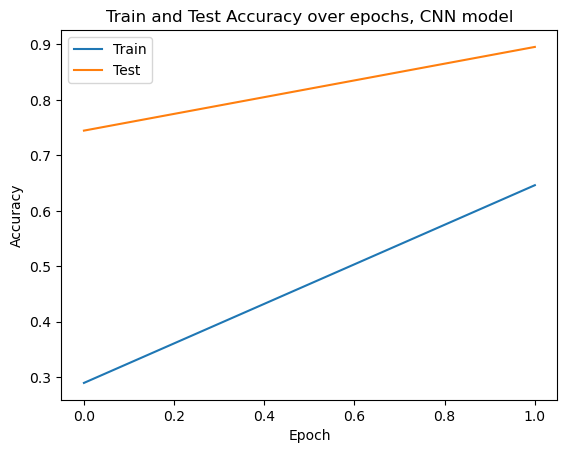

train_accs: [0.28968212060407644, 0.6462139613475552]
test_accs: [0.7446206115515289, 0.8955266138165345]


In [9]:
# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.legend()
plt.show()

print(f'train_accs: {train_accs}\ntest_accs: {test_accs}')

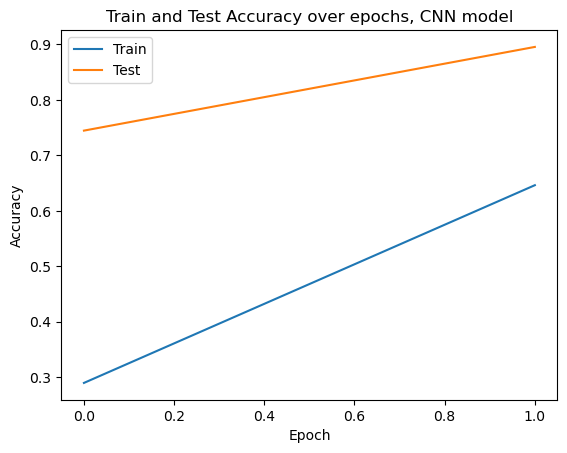

In [13]:
# Save the model
torch.save(CNN_model.state_dict(), 'vgg16_model.pth')


optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)

for var_name in optimizer.state_dict():
    print(f"Variable: {var_name}")
    print(optimizer.state_dict()[var_name])
    print("\n")


Variable: state
{}


Variable: param_groups
[{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]}]




In [15]:
# Test model on Cifar-10 to see if it will overfit

dataset_name = 'cifar10'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])


train_set, validation_set, test_set = get_dataset(dataset_name, validation_size=0.1)

# Get data
dataset_name = 'cifar10'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

train_set, validation_set, test_set = get_dataset(dataset_name, validation_size=0.1, transform=transform)

# Make dataloaders
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

import gc  # to clear memory

class VGG16(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, features_fore_linear=25088, dataset=None):
        super().__init__()

        # Helper hyperparameters
        conv_stride = 1
        pool_stride = 2
        conv_kernel = 3
        pool_kernel = 2
        dropout_probs = 0.5
        optim_momentum = 0.9
        weight_decay = 5e-4
        learning_rate = 1e-4  # Adjusted learning rate

        # Define features as per VGG16-D architecture
        self.features = torch.nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            # Block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Flatten(),  # Flatten layer
        ).to(device)

        # Fully connected layers (classifier)
        self.classifier = torch.nn.Sequential(
            nn.Linear(features_fore_linear, 4096),  # Index 0
            nn.ReLU(inplace=True),                  # Index 1
            # nn.Dropout(p=dropout_probs),
            nn.Linear(4096, 4096),                  # Index 2
            nn.ReLU(inplace=True),                  # Index 3
            # nn.Dropout(p=dropout_probs),
            nn.Linear(4096, num_classes)            # Index 4
        ).to(device)

        # Cross-entropy loss
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer
        self.optim = torch.optim.SGD(
            self.parameters(),
            lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay
        )

        self.dataset = dataset

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        self.train()
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()
                self.optim.step()
                self.optim.zero_grad()

                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()

                # Delete variables to free memory
                del inputs, targets, logits, loss
                gc.collect()

            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            if val_dataloader is not None:
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch+1} validation accuracy: {acc}")
                self.train()

        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        self.eval()
        total_acc = 0

        with torch.no_grad():
            for input_batch, label_batch in test_dataloader:
                input_batch, label_batch = input_batch.to(device), label_batch.to(device)
                logits = self(input_batch)
                total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)
        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        img = img.to(device).unsqueeze(0)
        self.eval()

        with torch.no_grad():
            logits = self(img)
            classification = torch.argmax(logits, dim=1)
        return img, classification

    def predict_random(self, num_predictions=16):
        random_indices = np.random.choice(len(self.dataset) - 1, num_predictions, replace=False)
        classifications = []
        labels = []
        images = []

        self.eval()
        with torch.no_grad():
            for idx in random_indices:
                img, label = self.dataset.__getitem__(idx)
                img_input = img.to(device).unsqueeze(0)
                logits = self(img_input)
                classification = torch.argmax(logits, dim=1)

                classifications.append(classification.cpu())
                labels.append(label)
                images.append(img.cpu())

        return classifications, labels, images

def get_vgg_weights(model):
    """
    Loads VGG16-D weights for the classifier to an already existing model.
    Also sets training to only the classifier.
    """
    # Load the complete VGG16 model with pre-trained weights
    temp = torchvision.models.vgg16(weights='DEFAULT').to(device)

    # Modify the classifier's last layer to match our number of classes
    num_classes = model.classifier[-1].out_features
    temp.classifier[6] = nn.Linear(4096, num_classes).to(device)

    # Copy the feature extractor weights
    model.features.load_state_dict(temp.features.state_dict())

    # Map the classifier layers correctly
    # Map temp.classifier[0] to model.classifier[0]
    model.classifier[0].weight.data = temp.classifier[0].weight.data.clone()
    model.classifier[0].bias.data = temp.classifier[0].bias.data.clone()

    # Map temp.classifier[3] to model.classifier[2]
    model.classifier[2].weight.data = temp.classifier[3].weight.data.clone()
    model.classifier[2].bias.data = temp.classifier[3].bias.data.clone()

    # We skip temp.classifier[6] because we've replaced it with our own layer

    # Freeze feature layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Update optimizer to only train classifier parameters
    model.optim = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=model.optim.defaults['lr'],
        momentum=model.optim.defaults['momentum'],
        weight_decay=model.optim.defaults['weight_decay']
    )

    return model

# Instantiate the model
in_channels = next(iter(train_dataloader))[0].shape[1]
features_fore_linear = 512 * 7 * 7  # Since images are resized to 224x224
CNN_model = VGG16(num_classes=10, in_channels=in_channels, features_fore_linear=features_fore_linear, dataset=test_set)

# Load pre-trained weights
CNN_model = get_vgg_weights(CNN_model)

train_epochs = 4
train_accs, test_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs, val_dataloader=test_dataloader)

# Plot train and test accuracies
plt.plot(range(1, train_epochs + 1), train_accs, label='Train')
plt.plot(range(1, train_epochs + 1), test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.legend()
plt.show()




